# Intel&reg; OSPRay - CPU and GPU

## Module Overview

Thi module provides an overview of Intel® OSPRay, detailing its role as an open-source, scalable, and portable ray tracing engine for high-performance visualization on various hardware architectures. OSPRay is described as part of the Intel Rendering Toolkit, offering an easy-to-use rendering library suitable for interactive applications across different platforms. It leverages modern instruction sets and builds on technologies like Intel Embree, Intel Open VKL, and Intel Open Image Denoise for efficient rendering performance. The tutorial covers OSPRay's API, outlining its low-level abstraction similar to OpenGL and categorizing objects such as OSPFrames, OSPData, OSPGeometry, and more. Additionally, a practical example, ospTutorial.cpp, is provided to illustrate OSPRay's program flow and usage and this module shows developers how to  use OSPRay to achieve high-performance visualization targeting CPUs and GPU devices.

## Learning Objectives

* Define the goals of Intel® OSPRay.
* Summarize the program flow and OSPRay API use in the ospTutorial.cpp code.
* Learn how to target CPU and GPU devices with OSPRay.


***
### 1. Intel&reg; OSPRay overview

Intel® OSPRay is an open source, scalable, and portable ray tracing engine for high-performance, high-fidelity visualization on Intel Architecture CPUs, Intel Xe GPUs, and ARM64 CPUs. OSPRay is part of the Intel Rendering Toolkit and is released under the permissive Apache 2.0 license.

The purpose of OSPRay is to provide an open, powerful, and easy-to-use rendering library that allows one to easily build ray tracing applications.  OSPRay can be suitable for interactive applications (including both surface- and volume-based visualizations). OSPRay runs on anything from laptops, to workstations, to compute nodes in HPC systems.

OSPRay internally builds on top of Intel Embree, Intel Open VKL, and Intel Open Image Denoise. The CPU implementation is based on Intel ISPC (Implicit SPMD Program Compiler) and fully exploits modern instruction sets like Intel SSE4, AVX, AVX2, AVX-512 and NEON to achieve high rendering performance. Hence, a CPU with support for at least SSE4.1 is required to run OSPRay on x86_64 architectures, or a CPU with support for NEON is required to run OSPRay on ARM64 architectures.

OSPRay’s GPU implementation (beta status) is based on the SYCL cross-platform programming language implemented by Intel oneAPI Data Parallel C++ (DPC++) and currently supports Intel® Arc™ GPUs on Linux and Windows, and Intel® Data Center GPU Flex and Max Series on Linux, exploiting ray tracing hardware support.


***

### 2. Intel&reg; OSPRay features

* **It is a library, not a visualization tool**. OSPRay is a _library_ that many different visualization tools can leverage.

* **A rendering solution for visualization tools**. Visualization tools often rely on middleware libraries (such as VTK). OSPRay does not replace such middleware, and focuses exclusively on the rendering component. This way OSPRay gives additional choices for rendering.

* **Focused on visualization rendering**. OSPRay emphasizes the rendering features needed for production and scientific visualization.

* **Focused on HPC visualization rendering**. We explicitly focus on problems that remain challenging for visualization applications, such as large data, volume rendering and advanced shading. In particular, we effectively perform rendering using HPC nodes along with targeting their CPU and GPU devices.

* **Focused on performance**. Though we do not have to achieve game-like frame rates, our implementation makes efficient use of threading, vectorization, and, if desired, node-parallelism; and leverages the most efficient ray tracing strategy available.



***

### 3. Intel OSPRay API
The Intel OSPRay API is a layer between visualization applications and low-level hardware resources. It is a low level of abstraction similar to that of OpenGL*, which is the level that modern visualization tools use for rendering. Similar to solutions in OpenGL and GPGPU, Intel OSPRay API focuses on a low-level data model.

***

### 4. API Categories
The OSPRay API exposes the following categories of objects:

* **OSPFrameBuffers** hold the final result of a rendered frame. Information held can contain, but is not limited to, pixel colors, depth values, and accumulation information.
* **OSPData** are 1D data arrays, similar to “buffers” in a GPGPU context. In addition to the typical scalar and 2-, 3-, or 4-dimensional vector data, data arrays can also contain references to other actors (including to other data arrays), in device-abstract fashion.
* **OSPGeometry** contain geometric surface primitives such as triangles, spheres, cylinders, etc.
* **OSPVolumes** represent 3D scalar fields that can produce, for any 3D position, a scalar value that a volume renderer can sample.
* **OSPTransferFunctions** map scalars to RGBA colors.
* **OSPModels** are collections of geometries and volumes – the parent objects of the hierarchy. Time-varying data are vectors of OSP- Models.
* **OSPCameras** generate primary rays for renderers to compute on.
* **OSPRenderers** use cameras, models, etc, to render pixels. OSPRay defines two renderers: 
    * `scivis` renderer that combines many rendering techniques into a single renderer. In this renderer we focus on the needs of scientific visualization: we implement an OpenGL-like material model, with customizable contributions of transparency, shadows, ambient occlusion, and fully integrated volume rendering.
    * `pathtracer` renderer, a fully photo-realistic renderer that can be used for generating high-quality publication images, and that has since seen adoption even outside of scientific visualization.
* **OSPLights, OSPTextures, and OSPMaterials** specify additional inputs for rendering, lighting, shading, etc.


**Note about committing**:
    An important aspect OSPRay is that parameters/data that affect any of the objects have to be passed using **ospCommit(object)**.
    If a user wants to change the state of an existing object (e.g., to change the origin of an already existing camera) parameters have to be recommitted.
    Commiting is important to ensure performance and consistency for devices crossing a PCI* bus, or across a network.


***
### 5. First Lesson: ospTutorial

In order to get a sense of basic API components we will work with the `ospTutorial.cpp` file which will create an image of two triangles, rendered with the pathtracer renderer.

The image `firstFrame.png` shows the result after one call to `ospRenderFrame`. Jagged edges and noise in the shadow can be seen. These are not incorrect renderings but are the result of the random nature of ray tracing. In future lessons we will learn how to address this issue with `ospRenderFrame` which will converge the resulting image.

#### 5.1 The Program Flow
The following is a general flow for the ospTutorial.cpp program. Although these steps are described for this program, they can be generalized for other OSPRay codes.

* Step 1 - Set up common objects to be used in the program
* Step 2 - Initialize the renderer using ospInit()
* Step 3 - Setup the camera and commit it
* Step 4 - Setup the scene
    * Step 4.1 - Feeding the model/vertex data to OSPRay
    * Step 4.2 - Create a material 
    * Step 4.3 - Put mesh into a model and apply material and release mesh
    * Step 4.4 - Put model into a group (collection of models), commit group and release model
    * Step 4.5 - Put group into an instance (give the group a world transform), commit instance and release group
    * Step 4.6 - Put instance in the world, commit world and release instance
    * Step 4.7 - Create a light for Ambient Occlusion, and put light in world. Commit world and release light
* Step 5  - Create the world bounds
* Step 6  - Create renderer
* Step 7  - Create and setup framebuffer
* Step 8  - Render one frame
* Step 9  - Access framebuffer and write the PNG file
* Step 10 - Shutdown system and clean up

In [1]:
%%writefile src/ospTutorial.cpp


// Copyright 2009 Intel Corporation
// SPDX-License-Identifier: Apache-2.0

/* This is a small example tutorial how to use OSPRay in an application.
 *
 * On Linux build it in the build_directory with
 *   g++ ../apps/ospTutorial/ospTutorial.cpp -I ../ospray/include \
 *       -I ../../rkcommon -L . -lospray -Wl,-rpath,. -o ospTutorial
 * On Windows build it in the build_directory\$Configuration with
 *   cl ..\..\apps\ospTutorial\ospTutorial.cpp /EHsc -I ..\..\ospray\include ^
 *      -I ..\.. -I ..\..\..\rkcommon ospray.lib
 * Above commands assume that rkcommon is present in a directory right "next
 * to" the OSPRay directory. If this is not the case, then adjust the include
 * path (alter "-I <path/to/rkcommon>" appropriately).
 */

#include <errno.h>
#include <stdint.h>
#include <stdio.h>
#ifdef _WIN32
#define NOMINMAX
#include <conio.h>
#include <malloc.h>
#include <windows.h>
#else
#include <alloca.h>
#endif

#include <vector>

#include "ospray/ospray_cpp.h"
#include "ospray/ospray_cpp/ext/rkcommon.h"
#include "rkcommon/utility/SaveImage.h"

using namespace rkcommon::math;

int main(int argc, const char **argv)
{
  // image size
  vec2i imgSize;
  imgSize.x = 1024; // width
  imgSize.y = 768; // height

  // camera
  vec3f cam_pos{0.f, 0.f, 0.f};
  vec3f cam_up{0.f, 1.f, 0.f};
  vec3f cam_view{0.1f, 0.f, 1.f};

  // triangle mesh data
  std::vector<vec3f> vertex = {vec3f(-1.0f, -1.0f, 3.0f),
      vec3f(-1.0f, 1.0f, 3.0f),
      vec3f(1.0f, -1.0f, 3.0f),
      vec3f(0.1f, 0.1f, 0.3f)};

  std::vector<vec4f> color = {vec4f(0.9f, 0.5f, 0.5f, 1.0f),
      vec4f(0.8f, 0.8f, 0.8f, 1.0f),
      vec4f(0.8f, 0.8f, 0.8f, 1.0f),
      vec4f(0.5f, 0.9f, 0.5f, 1.0f)};

  std::vector<vec3ui> index = {vec3ui(0, 1, 2), vec3ui(1, 2, 3)};

#ifdef _WIN32
  bool waitForKey = false;
  CONSOLE_SCREEN_BUFFER_INFO csbi;
  if (GetConsoleScreenBufferInfo(GetStdHandle(STD_OUTPUT_HANDLE), &csbi)) {
    // detect standalone console: cursor at (0,0)?
    waitForKey = csbi.dwCursorPosition.X == 0 && csbi.dwCursorPosition.Y == 0;
  }
#endif

  // initialize OSPRay; OSPRay parses (and removes) its commandline parameters,
  // e.g. "--osp:debug"
  OSPError init_error = ospInit(&argc, argv);
  if (init_error != OSP_NO_ERROR)
    return init_error;

  // use scoped lifetimes of wrappers to release everything before ospShutdown()
  {
    // create and setup camera
    ospray::cpp::Camera camera("perspective");
    camera.setParam("aspect", imgSize.x / (float)imgSize.y);
    camera.setParam("position", cam_pos);
    camera.setParam("direction", cam_view);
    camera.setParam("up", cam_up);
    camera.commit(); // commit each object to indicate modifications are done

    // create and setup model and mesh
    ospray::cpp::Geometry mesh("mesh");
    mesh.setParam("vertex.position", ospray::cpp::CopiedData(vertex));
    mesh.setParam("vertex.color", ospray::cpp::CopiedData(color));
    mesh.setParam("index", ospray::cpp::CopiedData(index));
    mesh.commit();

    // put the mesh into a model
    ospray::cpp::GeometricModel model(mesh);
    model.commit();

    // put the model into a group (collection of models)
    ospray::cpp::Group group;
    group.setParam("geometry", ospray::cpp::CopiedData(model));
    group.commit();

    // put the group into an instance (give the group a world transform)
    ospray::cpp::Instance instance(group);
    instance.commit();

    // put the instance in the world
    ospray::cpp::World world;
    world.setParam("instance", ospray::cpp::CopiedData(instance));

    // create and setup light for Ambient Occlusion
    ospray::cpp::Light light("ambient");
    light.commit();

    world.setParam("light", ospray::cpp::CopiedData(light));
    world.commit();

    // create renderer, choose Scientific Visualization renderer
    ospray::cpp::Renderer renderer("scivis");

    // complete setup of renderer
    renderer.setParam("aoSamples", 1);
    renderer.setParam("backgroundColor", 1.0f); // white, transparent
    renderer.commit();

    // create and setup framebuffer
    ospray::cpp::FrameBuffer framebuffer(
        imgSize.x, imgSize.y, OSP_FB_SRGBA, OSP_FB_COLOR | OSP_FB_ACCUM);
    framebuffer.clear();

    // render one frame
    framebuffer.renderFrame(renderer, camera, world);

    // access framebuffer and write its content as PPM file
    uint32_t *fb = (uint32_t *)framebuffer.map(OSP_FB_COLOR);
    rkcommon::utility::writePPM("firstFrameCpp.ppm", imgSize.x, imgSize.y, fb);
    framebuffer.unmap(fb);
    std::cout << "rendering initial frame to firstFrameCpp.ppm" << std::endl;

    // render 10 more frames, which are accumulated to result in a better
    // converged image
    for (int frames = 0; frames < 10; frames++)
      framebuffer.renderFrame(renderer, camera, world);

    fb = (uint32_t *)framebuffer.map(OSP_FB_COLOR);
    rkcommon::utility::writePPM(
        "accumulatedFrameCpp.ppm", imgSize.x, imgSize.y, fb);
    framebuffer.unmap(fb);
    std::cout << "rendering 10 accumulated frames to accumulatedFrameCpp.ppm"
              << std::endl;

    ospray::cpp::PickResult res =
        framebuffer.pick(renderer, camera, world, 0.5f, 0.5f);

    if (res.hasHit) {
      std::cout << "picked geometry [instance: " << res.instance.handle()
                << ", model: " << res.model.handle()
                << ", primitive: " << res.primID << "]" << std::endl;
    }
  }

  ospShutdown();

#ifdef _WIN32
  if (waitForKey) {
    printf("\n\tpress any key to exit");
    _getch();
  }
#endif

  return 0;
}


Overwriting src/ospTutorial.cpp


***

### 6. Build the Code

Execute the cell below to build the application.

In [2]:
! ./build_tutorial.sh

 
:: initializing oneAPI environment ...
   build_tutorial.sh: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: --force
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: embree -- latest
:: inspector -- latest
:: ipp -- latest
:: ippcp -- latest
:: ispc -- latest
:: itac -- latest
:: mkl -- latest
:: mpi -- latest
:: oidn -- latest
:: openpgl -- latest
:: openvkl -- latest
:: ospray -- latest
:: ospray_studio -- latest
:: rkcommon -- latest
:: rkutil -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
## ue67fcfb20b4827a1ed6842c10ec58c1 is compiling OSPRay_Intro
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detec

***

### 7. Run the Program Targeting CPU or GPU

The method OSPRay employs to determine the architecture it targets during program execution is very straightforward:

- For CPU: ./bin/ospTutorial --osp:load-modules=cpu --osp:device=cpu
- For GPU: ./bin/ospTutorial --osp:load-modules=gpu --osp:device=gpu

This method is highly convenient for developers to achieve high performance in execution and high efficiency when developing.

In [3]:
! ./run_tutorial_CPU.sh

Running ospTutorial targeting the CPU with the command:

bin/ospTutorial --osp:load-modules=cpu --osp:device=cpu

rendering initial frame to firstFrameCpp.ppm
rendering 10 accumulated frames to accumulatedFrameCpp.ppm
picked geometry [instance: 0x55a38151c090, model: 0x55a381517440, primitive: 1]


In [4]:
! ./run_tutorial_GPU.sh

Running ospTutorial targeting the CPU with the command:

bin/ospTutorial --osp:load-modules=gpu --osp:device=gpu

rendering initial frame to firstFrameCpp.ppm
rendering 10 accumulated frames to accumulatedFrameCpp.ppm
picked geometry [instance: 0, model: 0, primitive: 4294967295]


***

### 8. Convert the Resulting ppm Image to png Extension

First we have to install **pillow**, which is the library we are going to use for the conversion:

In [5]:
! pip install pillow

Defaulting to user installation because normal site-packages is not writeable


Next, it is necessary to update de kernel: Go to `Kernel` -> `Restart Kernel...` for the Kernel to be aware of **pillow**. Now we can proceed with the conversion:

In [6]:
from PIL import Image
images = ['firstFrameCpp.ppm', 'accumulatedFrameCpp.ppm']
for i in images:
    img = Image.open(i)
    img.save(i[:-4]+'.png', format="png")
    print(f"{i} converted from ppm to png")

firstFrameCpp.ppm converted from ppm to png
accumulatedFrameCpp.ppm converted from ppm to png


***

### 9. View the Converted Images

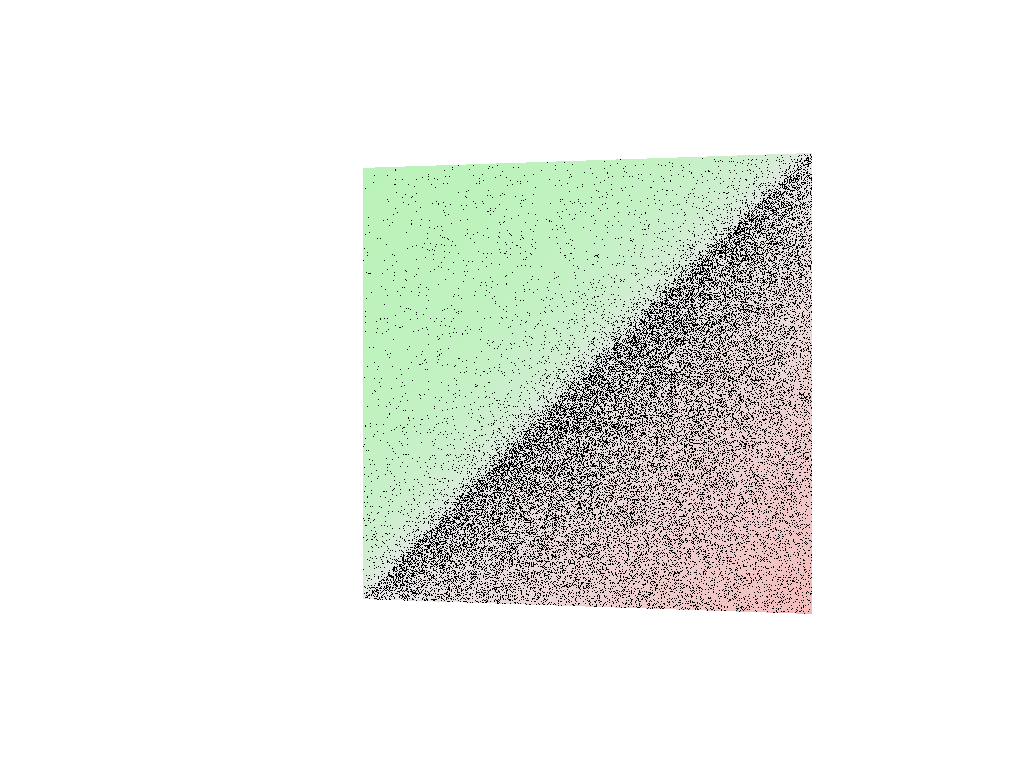

In [7]:
from IPython.display import Image
Image("firstFrameCpp.png")

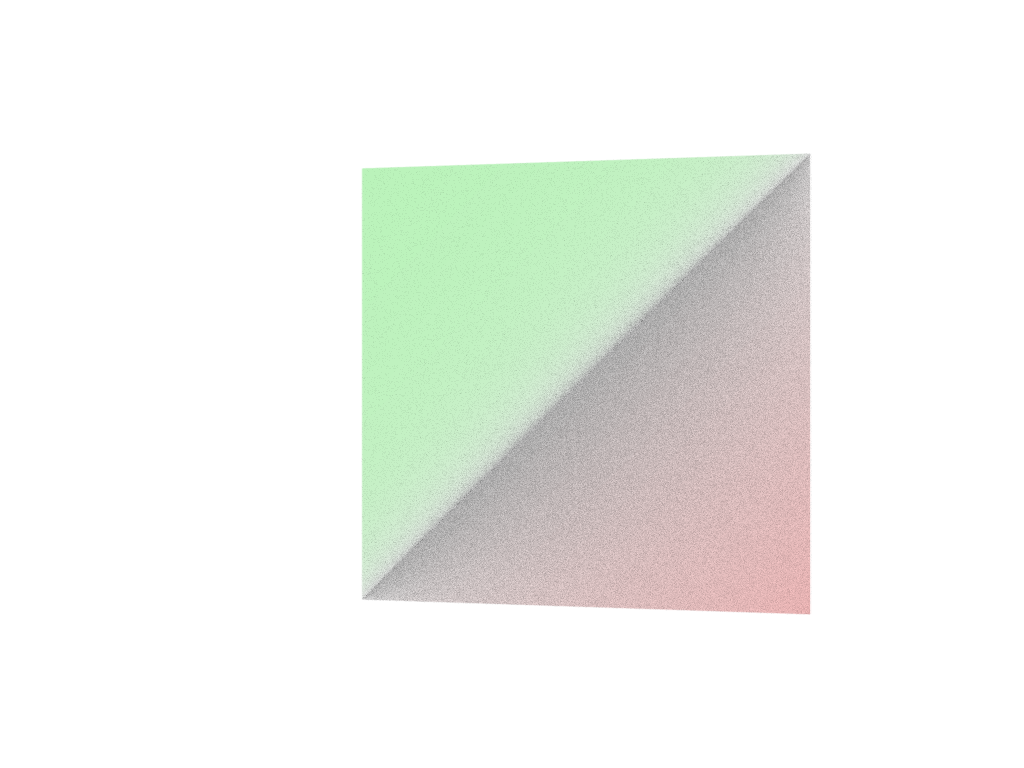

In [8]:
Image("accumulatedFrameCpp.png")

***
## Summary

In this module you learned:

* Defined what Intel® OSPRay is about.
* Defined the goals of Intel® OSPRay.
* Summarized a basic OSPRay program flow.
* Learned how to choose CPU or GPU for the execution of an OSPRay program.

## Resources
* Intel&reg; OSPRay API manual: https://www.ospray.org/documentation.html
* M. Pharr and G. Humphreys. Physically Based Rendering: From Theory to Implementation. Morgan Kaufman, 3rd edition, 2016.
* P. Shirley. Ray Tracing in One Weekend Series. Editors: Steve Hollasch, Trevor David Black. Version/Edition: v3.2.0. Date: 2020-07-18. URL (series): https://raytracing.github.io/
* I. Wald et al., "OSPRay - A CPU Ray Tracing Framework for Scientific Visualization," in IEEE Transactions on Visualization and Computer Graphics, vol. 23, no. 1, pp. 931-940, Jan. 2017, doi: 10.1109/TVCG.2016.2599041.


***